In [ ]:
####
# Going through the code from Hands-On Machine Learning with SciKit-Learn and Tensor Flow
# Aurelien Geron
#https://github.com/ageron/handson-ml3/blob/main/03_classification.ipynb

In [1]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt

In this notebook, I will be going through the MNIST dataset. This dataset is a set of handwritten numbers between 0-9.

The goal will be to predict which numbers are 5.

### Download the Data

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

C:\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [6]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [7]:
X, y = mnist.data, mnist.target # the entire dataset, pictures and results
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

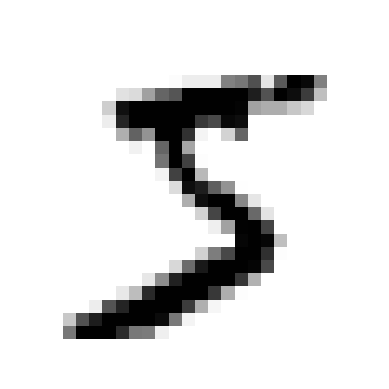

In [17]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")
plot_digit(X[0])
plt.show()

In [11]:
y[0]

'5'

In [12]:
X.shape

(70000, 784)

In [13]:
# This splits the entire dataset into test and train sets,
# the training data set is 60,000 out of 70,000
# the testing data set is 10,000 out of 70,000
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Train a Binary Classifier

In [15]:
# First, split the training and testing results into 5 or not 5's....
y_train_5 = (y_train == '5')  # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

SGDClassifier supports multi-class classification by combining multiple binary classifiers in a “one versus all” (OVA) scheme. For each of the classes, a binary classifier is learned that discriminates between that and all other classes.

In [16]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
# use y_train_5 to get 5 or not 5 results...

SGDClassifier(random_state=42)

In [18]:
sgd_clf.predict([X[0]]) # checking the image of the five from above !

array([ True])

### Performance Measures

1. Cross Validation

Evaluate the accuracy of the model using the testing dataset. Cross validation will provide three values from the number of "k-folds" specified.
Cross-Validation has two main steps: splitting the data into subsets (called folds) and rotating the training and validation among them.
https://towardsdatascience.com/what-is-cross-validation-60c01f9d9e75

In [19]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

These are pretty good results ! However, lets check how the model scores if all data is "not a 5"

In [20]:
from sklearn.dummy import DummyClassifier
# DummyClassifier makes predictions that ignore the input features.

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [21]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

These results are still high, 90%, even though none of them are 5s. This is because only 10 % of the data is actually 5s, so if 100% of the predictions are simply "not a 5", the model will be 90% accurate.

For this reason, you need to use multiple types of performance measures.

2. Confusion Matrix

A confusion matrix is helpful for measuring recall, precision, specificity, and accuracy. The matrix is a 2x2 with true positive, true negative, false positive, and false negative, as seen in this example:
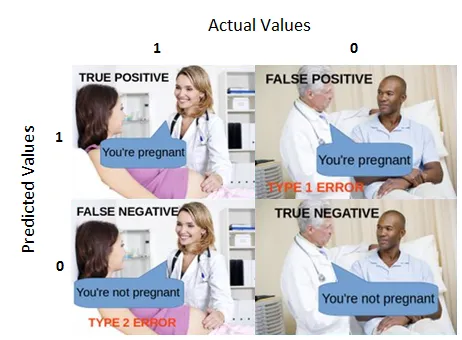
https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62

In [23]:
from sklearn.model_selection import cross_val_predict
# Generate cross-validated estimates for each input data point.

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In this case, there are more false negatives than false positives. In some cases, more false negatives is better. In other cases, more flast positives is better.

3. Precision vs. Recall

Precision - from all classes predicted as positive, how many are actually positive

Recall - from all the positive classes, how many were predicted correctly

Accuracy - from all classes (postive & negative), how many were predicted correctly

In [25]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # == 3530 / (687 + 3530)

0.8370879772350012

In [26]:
recall_score(y_train_5, y_train_pred)  # == 3530 / (1891 + 3530)

0.6511713705958311

In [31]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
threshold = 3000

In [32]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

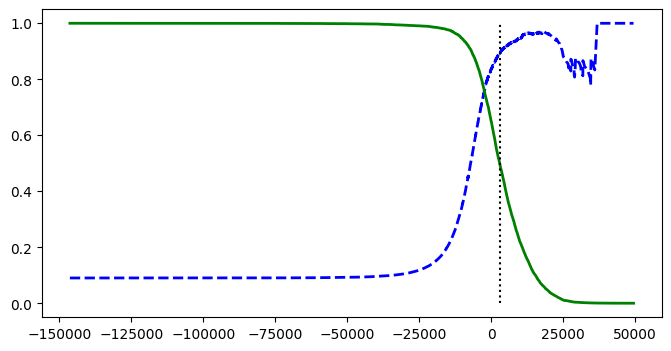

In [38]:
plt.figure(figsize=(8, 4))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.show()

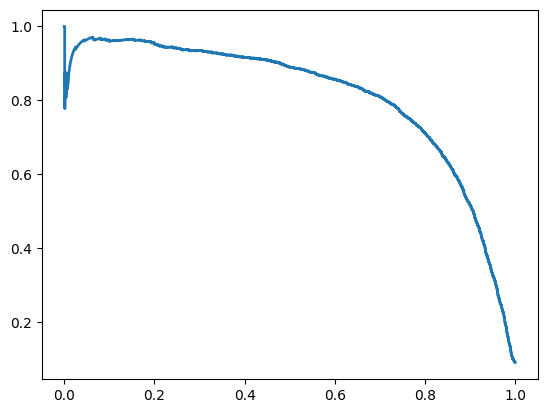

In [36]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.show()

4. The ROC Curce

Recall

Specificity - the model's ability to predict a true negative

FPR - false positive rate (1-specificity)

Sensitivity - a measure of how well a model can detect positive instances (inverse of specificity)




